# Wikishop project with BERT

Online store "Wikishop" launches a new service. Now users can edit and supplement product descriptions, just like in wiki communities. That is, clients propose their edits and comment on the changes of others. The store needs a tool that will look for toxic comments and submit them for moderation.

Train the model to classify comments as positive or negative. At your disposal is a dataset with markup on the toxicity of edits.

Build a model with a quality metric *F1* of at least 0.75.

**Instructions for the implementation of the project**

1. Download and prepare data.
2. Train different models.
3. Draw conclusions.

You don't have to use *BERT* to run the project, but you can try.

**Data Description**

The data is in the `toxic_comments.csv` file. The *text* column contains the text of the comment, and *toxic* is the target attribute.

## Preparation

In [1]:
#load the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
from tqdm import notebook

import nltk
from nltk.corpus import stopwords as nltk_stopwords
import torch
import transformers
from transformers import BertTokenizer
from transformers import AutoModel, AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoost, CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
#save the dataset
try:
    toxic = pd.read_csv('/datasets/toxic_comments.csv')
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

In [3]:
#look at the dataset
toxic.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [4]:
#take a look at general information about the dataset
toxic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


The dataset has two columns and 159,571 rows. There are no passes. Let's see if there are duplicates in the dataset.

In [5]:
print('Number of gaps in the dataset:', toxic.duplicated().sum())

Number of gaps in the dataset: 0


And now let's look at the ratio of negative comments (feature 1) and positive comments (feature 0).

(-1.25, 1.25, -1.25, 1.25)

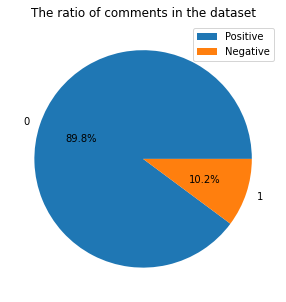

In [6]:
toxic['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.legend(['Positive','Negative'])
plt.title('The ratio of comments in the dataset')
plt.axis('off')

There are only 10.2% of negative comments, 89.8% of positive comments, there is a large imbalance in the sample.

Let's take 5,000 random entries from the sample so as not to create embeddings for too long and add negative and positive comments in a 50/50 ratio.

(-1.25, 1.25, -1.25, 1.25)

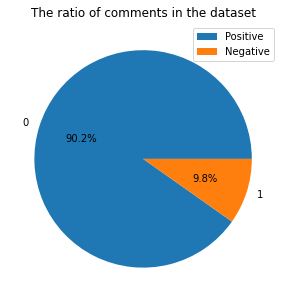

In [7]:
batch_toxic = toxic.sample(5000, random_state=12345).reset_index(drop=True)

#check the ratio of positive and negative comments
batch_toxic['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.legend(['Positive','Negative'])
plt.title('The ratio of comments in the dataset')
plt.axis('off')

We initialize the tokenizer as an object of the BertTokenizer() class.

In [8]:
#take an already trained model to detect toxic comments
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = batch_toxic['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)

#initialize the BertModel class model itself
model = AutoModel.from_pretrained('unitary/toxic-bert')

(5000, 512)


Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
%%time

#the BERT model creates embeddings in batches. To have enough RAM, let's make the batch size small
batch_size = 200

#make an empty list for storing embeddings
embeddings = []


#Let's make a batch loop. The notebook function will display progress
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        
        #convert data to tensors format
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        #transform the mask
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            #to get embeddings for a batch, pass data and a mask to the model
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        #convert elements using numpy() method to type numpy.array
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: total: 4h 35min 46s
Wall time: 46min 50s


In [10]:
#collect all embeddings in a feature matrix
features = np.concatenate(embeddings) 
#and load the target feature
target = batch_toxic['toxic']

In [11]:
#prepare training, validation and test sets in a ratio of 3:1:1
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345)

print('Training sample size:', len(target_train))
print('Test sample size:', len(target_test))
print('Validation sample size:', len(target_valid))

Training sample size: 3000
Test sample size: 1000
Validation sample size: 1000


Embeddings are ready, now we will train models on them.

## Training

We will train 4 models: logistic regression, random forest, Catboost and LightGBM.

In [12]:
%%time

#logistic regression
logistic_model = LogisticRegression(random_state=12345, solver='saga')
logistic_model.fit(features_train, target_train)

print('F1 logistic regression:', cross_val_score(
    logistic_model, features_valid, target_valid, cv=5, scoring='f1').mean())

F1 logistic regression: 0.9525318309141838
CPU times: total: 4.83 s
Wall time: 4.61 s


In [13]:
%%time

#random forest

forest_model = RandomForestClassifier(random_state=12345)
forest_params = {'n_estimators':range(10, 50, 10), 'max_depth':range(10, 20)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=5, scoring='f1', n_jobs=-1)
forest_grid.fit(features_train, target_train)

print('Best Random Forest Options:', forest_grid.best_params_)
print('F1 of the random forest is:',  cross_val_score(
    forest_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Best Random Forest Options: {'max_depth': 12, 'n_estimators': 40}
F1 of the random forest is: 0.9349524658348187
CPU times: total: 3.41 s
Wall time: 30.4 s


In [14]:
%%time

#Catboost

cat_model = CatBoostClassifier(iterations=100, verbose=False, random_state=12345)
cat_params = {'learning_rate':[0.05, 0.1],
              'depth':[5, 7]}
cat_grid = GridSearchCV(cat_model, cat_params, cv=3, scoring='f1', n_jobs=-1)
cat_grid.fit(features_train, target_train)

print('Best Catboost Options:', cat_grid.best_params_)
print('F1 Catboost makes up:', cross_val_score(
    cat_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Best Catboost Options: {'depth': 7, 'learning_rate': 0.05}
F1 Catboost makes up: 0.9525318309141838
CPU times: total: 4min 10s
Wall time: 5min 24s


In [15]:
%%time

#LightGBM

gbm_model = LGBMClassifier(random_state=12345)
gbm_params = {'n_estimators':[100, 150],
              'num_leaves':[10, 15, 20]}
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=5, scoring='f1', n_jobs=-1)
gbm_grid.fit(features_train, target_train)

print('Best LightGBM Options:', gbm_grid.best_params_)
print('F1 LightGBM is:', cross_val_score(
    gbm_grid, features_valid, target_valid, cv=5, scoring='f1').mean())

Best LightGBM Options: {'n_estimators': 150, 'num_leaves': 15}
F1 LightGBM is: 0.9471536796536796
CPU times: total: 46.2 s
Wall time: 1min 41s


All models showed an excellent f1 result, and the smallest result was obtained for the random forest equal to 0.934. At the same time, Catboost turned out to be slightly better than all with a score of 0.952. We will check it on a test sample.

Let's check the adequacy of our model in comparison with the constant model.

In [16]:
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(features_train, target_train)
dummy_clf_pred = dummy_clf.predict(features_train)
print('Accuracy:', dummy_clf.score(dummy_clf_pred, target_train))
print('F1 Dummy:', cross_val_score(dummy_clf, features_valid, target_valid, cv=5, scoring='f1').mean())

Accuracy: 0.894
F1 Dummy: 0.0


F1 of the Dummy model is 0.0, and the accuracy is 0.894, which is logical, because this is the ratio of zeros and ones in the dataset.

In [17]:
data={'Model': ['Linear Regression', 'RandomForest', 'Catboost', 'LightGBM', 'Dummy Model'],
      'F1:': [0.952, 0.934, 0.952, 0.947, 0.0]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Model,F1:
0,Linear Regression,0.952
1,RandomForest,0.934
2,Catboost,0.952
3,LightGBM,0.947
4,Dummy Model,0.000


Let's check Catboost with the best parameters on a test set.

In [18]:
model = CatBoostClassifier(iterations=100, verbose=False,
                           random_state=12345, learning_rate=0.05, depth=7)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('F1 Catboost on the test set is:',
     cross_val_score(model, features_test, target_test, cv=5, scoring='f1').mean())

F1 Catboost on the test set is: 0.9646054171054171


We got an excellent result f1 equal to 0.964, which is even higher than on the validation set.

## Conclusion

1. A pre-trained BERT neural network was used to prepare the text.
2. A sample of 5000 random records was taken from the entire dataset to create embeddings.
3. Four models were chosen for training: logistic regression, random forest, Catboost and LightGBM.
4. All models showed an excellent result f1, but the Catboost model showed a slightly better result and f1 equal to 0.964 was obtained on the training set, and this result exceeded the result of the validation set.